In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
csv_path = './content/MyDrive/drive/data/csv'
artist_train = pd.read_csv('/content/drive/MyDrive/data/csv/Artist/artist_train')
# lets visualize one imag
base_url = '/content/drive/MyDrive/data/images'
# lets start creating data
artist = '/content/drive/MyDrive/data/csv/Artist'
genre = '/content/drive/MyDrive/data/csv/Genre'
style = '/content/drive/MyDrive/data/csv/Style'
data_dir = '/content/drive/MyDrive/data/csv'

artist_train_path = data_dir + '/artist_train.csv'
artist_val_path = data_dir + '/artist_val.csv'
artist_class_path = data_dir + '/artist_class.txt'

genre_train_path = data_dir + '/genre_train.csv'
genre_val_path = data_dir + '/genre_val.csv'
genre_class_path = data_dir + '/genre_class.txt'

style_train_path = data_dir + '/style_train.csv'
style_val_path = data_dir + '/style_val.csv'
style_class_path = data_dir + '/style_class.txt'

artist_train = pd.read_csv(data_dir + '/artist_train.csv')
artist_val = pd.read_csv(data_dir + '/artist_val.csv')
artist_class = pd.read_csv(artist_class_path, header=None, names=["artist_name"])

genre_train = pd.read_csv(data_dir + '/genre_train.csv')
genre_val = pd.read_csv(data_dir + '/genre_val.csv')
genre_class = pd.read_csv(genre_class_path, header=None, names=["genre_name"])


style_train = pd.read_csv(data_dir + '/style_train.csv')
style_val = pd.read_csv(data_dir + '/style_val.csv')
style_class = pd.read_csv(style_class_path, header=None, names=["style_name"])

# genre_class['genre_name'][1]
len(style_class)

27

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from collections import defaultdict
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define dataset class
class BalancedArtDataset(Dataset):
    def __init__(self, csv_file, img_dir, class_mapping, transform=None, images_per_class=32):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.class_mapping = class_mapping
        self.transform = transform
        self.images_per_class = images_per_class

        # Filter out missing images
        print("Filtering missing images...")
        self.data = self.data[self.data.iloc[:, 0].apply(lambda x: os.path.exists(os.path.join(img_dir, str(x))))]

        # Group images by class
        print("Grouping images by class...")
        self.class_images = defaultdict(list)
        for _, row in tqdm(self.data.iterrows(), total=len(self.data), desc="Processing rows"):
            self.class_images[row.iloc[1]].append(row)

        # Balance dataset with 32 images per class
        print("Balancing dataset...")
        self.final_data = []
        all_images = []
        for cls, images in tqdm(self.class_images.items(), total=len(self.class_images), desc="Processing classes"):
            if len(images) >= images_per_class:
                selected_images = random.sample(images, images_per_class)
            else:
                selected_images = images[:]
                all_images.extend(images)  # Store extra images for filling
            self.final_data.extend(selected_images)

        # Fill missing slots with extra images
        print("Filling missing slots...")
        needed_images = images_per_class * len(self.class_images) - len(self.final_data)
        if needed_images > 0:
            self.final_data.extend(random.sample(all_images, min(needed_images, len(all_images))))

        # Shuffle dataset
        print("Shuffling dataset...")
        random.shuffle(self.final_data)

        # Count images per class
        self.class_counts = defaultdict(int)
        for row in self.final_data:
            self.class_counts[row.iloc[1]] += 1

    def __len__(self):
        return len(self.final_data)

    def __getitem__(self, idx):
        row = self.final_data[idx]
        img_path = os.path.join(self.img_dir, str(row.iloc[0]))
        label = row.iloc[1]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


    def visualize_class_distribution(self):
        plt.figure(figsize=(12, 6))
        plt.bar(self.class_counts.keys(), self.class_counts.values(), color='skyblue')
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.title("Class Distribution in Balanced Dataset")
        plt.xticks(rotation=45)
        plt.show()

    def visualize_samples(self, num_samples=10):
        fig, axes = plt.subplots(1, num_samples, figsize=(40, 20))
        for i in range(num_samples):
            image, label = self.__getitem__(random.randint(0, len(self) - 1))
            image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
            image = (image * 0.5) + 0.5  # Unnormalize
            axes[i].imshow(image)
            axes[i].set_title(f"Class: {label} {genre_class['genre_name'][label]}")
            axes[i].axis("off")
        plt.show()

    # Function to compare artist and genre relationships



# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create balanced artist dataset


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm  # Import tqdm for progress bar

def test_model(model, dataset, device):
    model.eval()  # Set model to evaluation mode
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)  # Adjust batch size as needed
    criterion = torch.nn.CrossEntropyLoss()  # Loss function

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed during evaluation
        progress_bar = tqdm(dataloader, desc="Testing", leave=True)  # tqdm progress bar
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # Get predicted class
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update tqdm bar with current loss
            progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    print(f"\nTest Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

# Example usage:
# test_model(model, artist_test_balanced_dataset, device)


## Artist Models

In [ ]:
print("Creating balanced artist dataset...")

artist_test_balanced_dataset = BalancedArtDataset(artist_val_path, "/content/drive/MyDrive/data/images", artist_class_path, transform=transform, images_per_class=50)



Creating balanced artist dataset...
Filtering missing images...
Grouping images by class...


Processing rows: 100%|██████████| 5706/5706 [00:00<00:00, 12961.68it/s]


Balancing dataset...


Processing classes: 100%|██████████| 23/23 [00:00<00:00, 14224.27it/s]

Filling missing slots...
Shuffling dataset...


In [ ]:
num_classes = len(artist_class)


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the full model
checkpoint_path = "/content/drive/MyDrive/art_model/artist_model_resnet18_200.pth"
model1 = torch.load(checkpoint_path, map_location=device, weights_only=False)  # Explicitly allow full model loading

# Set to evaluation mode
model1.eval()

print("Model successfully loaded!")


Model successfully loaded!


In [ ]:
# Example usage:
#artist_model_resnet18_200
model1_result = test_model(model1, artist_test_balanced_dataset, device)


Testing: 100%|██████████| 36/36 [07:38<00:00, 12.73s/it, loss=1.3]


Test Loss: 1.8682, Accuracy: 57.22%


In [ ]:
num_classes

23

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model2 = models.resnet18(weights=None)  # Initialize model without pre-trained weights
model2.fc = nn.Linear(model2.fc.in_features, num_classes)  # Modify the FC layer
model2 = model2.to(device)

# Load state_dict (weights) into model
checkpoint_path = "/content/drive/MyDrive/art_model/artist_finetunned_resnet18_200.pth"
state_dict = torch.load(checkpoint_path, map_location=device)  # Load weights
model2.load_state_dict(state_dict)  # Load into model

# Set to evaluation mode
model2.eval()

print("Model successfully loaded!")


Model successfully loaded!


In [ ]:
# Example usage:
#artist_finetunned_resnet18_200
model2_result = test_model(model2, artist_test_balanced_dataset, device)


Testing: 100%|██████████| 36/36 [02:09<00:00,  3.59s/it, loss=0.211]


Test Loss: 0.7194, Accuracy: 79.48%


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model3 = models.resnet50(weights=None)  # Initialize model without pre-trained weights
model3.fc = nn.Linear(model3.fc.in_features, num_classes)  # Modify the FC layer
model3 = model3.to(device)

# Load state_dict (weights) into model
checkpoint_path = "/content/drive/MyDrive/art_model/artist_model_resnet50_200.pth"
state_dict = torch.load(checkpoint_path, map_location=device)  # Load weights
model3.load_state_dict(state_dict)  # Load into model

# Set to evaluation mode
model3.eval()

print("Model successfully loaded!")


Model successfully loaded!


In [ ]:
# Example usage:
#artist_model_resnet50_200
model3_result = test_model(model3, artist_test_balanced_dataset, device)


Testing: 100%|██████████| 36/36 [05:08<00:00,  8.57s/it, loss=0.265]


Test Loss: 0.7576, Accuracy: 79.22%


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model4 = models.resnet50(weights=None)  # Initialize model without pre-trained weights
model4.fc = nn.Linear(model4.fc.in_features, num_classes)  # Modify the FC layer
model4 = model4.to(device)

# Load state_dict (weights) into model
checkpoint_path = "/content/drive/MyDrive/art_model/artist_model_ReduceLROnPlateau_resnet50_200.pth"
state_dict = torch.load(checkpoint_path, map_location=device)  # Load weights
model4.load_state_dict(state_dict)  # Load into model

# Set to evaluation mode
model4.eval()

print("Model successfully loaded!")


Model successfully loaded!


In [ ]:
# Example usage:
#artist_model_ReduceLROnPlateau_resnet50_200
model4_result = test_model(model4, artist_test_balanced_dataset, device)


Testing: 100%|██████████| 36/36 [05:17<00:00,  8.81s/it, loss=0.314]


Test Loss: 0.7825, Accuracy: 78.35%


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Define the same model architecture
class ResNetRNN(nn.Module):
    def __init__(self, num_classes, hidden_size=256, num_layers=2):
        super(ResNetRNN, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()  # Remove FC layer to get feature maps

        # LSTM layer
        self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Bidirectional doubles the hidden size

    def forward(self, x):
        features = self.resnet(x)  # Shape: (batch_size, 2048)
        features = features.unsqueeze(1)  # Add time dimension: (batch_size, 1, 2048)

        lstm_out, _ = self.lstm(features)
        lstm_out = lstm_out[:, -1, :]  # Last timestep output

        output = self.fc(lstm_out)
        return output

# Load model
num_classes = 23  # Update with actual number of classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model5 = ResNetRNN(num_classes=num_classes).to(device)

# Load saved model weights
checkpoint_path = "/content/drive/MyDrive/art_model/artist_resnet50_lstm_model.pth"
model5.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Set model to evaluation mode
model5.eval()
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [ ]:
# artist_resnet50_lstm_model
# Example usage:
#artist_model_ReduceLROnPlateau_resnet50_200
model5_result = test_model(model5, artist_test_balanced_dataset, device)


Testing: 100%|██████████| 36/36 [04:46<00:00,  7.96s/it, loss=0.392]


Test Loss: 0.8610, Accuracy: 74.78%


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model0 = models.resnet18(weights=None)  # Initialize model without pre-trained weights
model0.fc = nn.Linear(model0.fc.in_features, num_classes)  # Modify the FC layer
model0 = model0.to(device)

# Load state_dict (weights) into model
checkpoint_path = "/content/drive/MyDrive/art_model/artist_model_resnet18_32.pth"
state_dict = torch.load(checkpoint_path, map_location=device)  # Load weights
model0.load_state_dict(state_dict)  # Load into model

# Set to evaluation mode
model0.eval()

print("Model successfully loaded!")


Model successfully loaded!


In [ ]:
# Example usage:
#artist_model_resnet18_32
model0_result = test_model(model0, artist_test_balanced_dataset, device)


Testing: 100%|██████████| 36/36 [02:06<00:00,  3.52s/it, loss=4.16]


Test Loss: 3.9084, Accuracy: 30.87%


In [ ]:
import pandas as pd

# Number of classes
num_classes = len(artist_class)  # Update this based on your dataset

# Store all model results in a list
results = [
    ("artist_model_resnet18_32", model0_result[0], model0_result[1], 32, 32 * num_classes),
    ("artist_model_resnet18_200", model1_result[0], model1_result[1], 200, 200 * num_classes),
    ("artist_finetunned_resnet18_200", model2_result[0], model2_result[1], 200, 200 * num_classes),
    ("artist_model_finetunned_resnet50_200", model3_result[0], model3_result[1], 200, 200 * num_classes),
    ("artist_model_finetuned_with_ReduceLROnPlateau_resnet50_200", model4_result[0], model4_result[1], 200, 200 * num_classes),
     ("artist_resnet50_lstm_model", model5_result[0], model5_result[1], 200, 200 * num_classes),
]

# Create a DataFrame
df = pd.DataFrame(results, columns=["Model", "Test Loss", "Accuracy (%)", "Images per Class", "Total Images"])

# Display the table
print(df)


                                               Model  Test Loss  Accuracy (%)  \
0                           artist_model_resnet18_32   3.908368     30.869565   
1                          artist_model_resnet18_200   1.868159     57.217391   
2                     artist_finetunned_resnet18_200   0.719381     79.478261   
3               artist_model_finetunned_resnet50_200   0.757617     79.217391   
4  artist_model_finetuned_with_ReduceLROnPlateau_...   0.782543     78.347826   
5                         artist_resnet50_lstm_model   0.861030     74.782609   

   Images per Class  Total Images  
0                32           736  
1               200          4600  
2               200          4600  
3               200          4600  
4               200          4600  
5               200          4600  


In [ ]:
from tabulate import tabulate

# Print the table in a structured format
print(tabulate(df, headers='keys', tablefmt='grid'))


+----+------------------------------------------------------------+-------------+----------------+--------------------+----------------+
|    | Model                                                      |   Test Loss |   Accuracy (%) |   Images per Class |   Total Images |
+====+============================================================+=============+================+====================+================+
|  0 | artist_model_resnet18_32                                   |    3.90837  |        30.8696 |                 32 |            736 |
+----+------------------------------------------------------------+-------------+----------------+--------------------+----------------+
|  1 | artist_model_resnet18_200                                  |    1.86816  |        57.2174 |                200 |           4600 |
+----+------------------------------------------------------------+-------------+----------------+--------------------+----------------+
|  2 | artist_finetunned_resnet18_200    

<ipython-input-53-7035ce5ebb8c>:48: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


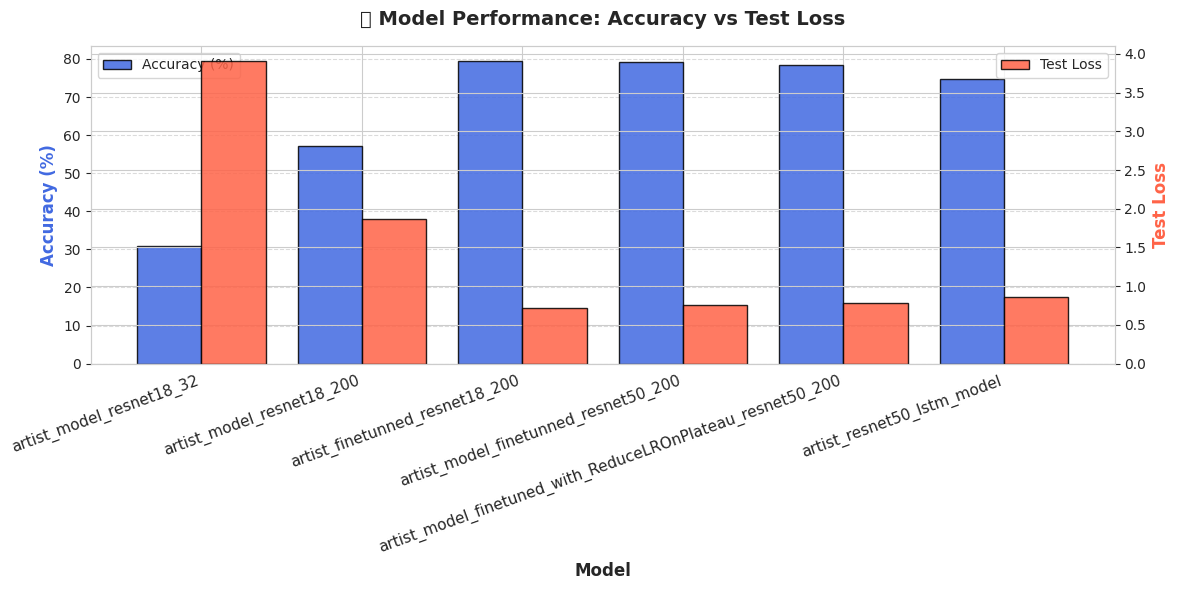

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply Seaborn style
sns.set_style("whitegrid")

# Create figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# X-axis labels and positions
x_labels = df["Model"]
x = np.arange(len(x_labels))

# Plot Accuracy Bars
ax1.bar(
    x - 0.2, df["Accuracy (%)"], width=0.4, label="Accuracy (%)",
    color='royalblue', edgecolor="black", alpha=0.85
)

# Create a secondary axis for Test Loss
ax2 = ax1.twinx()
ax2.bar(
    x + 0.2, df["Test Loss"], width=0.4, label="Test Loss",
    color='tomato', edgecolor="black", alpha=0.85
)

# Formatting
ax1.set_xlabel("Model", fontsize=12, fontweight="bold")
ax1.set_ylabel("Accuracy (%)", color='royalblue', fontsize=12, fontweight="bold")
ax2.set_ylabel("Test Loss", color='tomato', fontsize=12, fontweight="bold")

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=20, ha="right", fontsize=11)

# Add grid lines
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Add Legends
ax1.legend(loc="upper left", fontsize=10, frameon=True)
ax2.legend(loc="upper right", fontsize=10, frameon=True)

# Add title
plt.title("📊 Model Performance: Accuracy vs Test Loss", fontsize=14, fontweight="bold", pad=15)

# Improve layout
plt.tight_layout()
plt.show()


## Style Models

In [ ]:
print("Creating balanced style dataset...")

style_test_balanced_dataset = BalancedArtDataset(style_val_path, "/content/drive/MyDrive/data/images", style_class_path, transform=transform, images_per_class=50)



Creating balanced style dataset...
Filtering missing images...
Grouping images by class...


Processing rows: 100%|██████████| 24421/24421 [00:02<00:00, 11168.63it/s]


Balancing dataset...


Processing classes: 100%|██████████| 27/27 [00:00<00:00, 11185.92it/s]

Filling missing slots...
Shuffling dataset...


In [ ]:
num_style_classes = len(style_class)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


style_model1 = models.resnet18(weights=None)  # Initialize model without pre-trained weights
style_model1.fc = nn.Linear(style_model1.fc.in_features, num_style_classes)  # Modify the FC layer
style_model1 = style_model1.to(device)

# Load state_dict (weights) into model
checkpoint_path =  "/content/drive/MyDrive/art_model/style_model_resnet18_32.pth"
state_dict = torch.load(checkpoint_path, map_location=device)  # Load weights
style_model1.load_state_dict(state_dict)  # Load into model

# Set to evaluation mode
style_model1.eval()

print("Model successfully loaded!")


Model successfully loaded!


In [ ]:
# Example usage:
#style_model_resnet18_32
style_model1_result = test_model(style_model1, style_test_balanced_dataset, device)


Testing: 100%|██████████| 43/43 [09:21<00:00, 13.06s/it, loss=2.14]


Test Loss: 2.0344, Accuracy: 39.56%


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


style_model2 = models.resnet18(weights=None)  # Initialize model without pre-trained weights
style_model2.fc = nn.Linear(style_model2.fc.in_features, num_style_classes)  # Modify the FC layer
style_model2 = style_model2.to(device)

# Load state_dict (weights) into model
checkpoint_path =  "/content/drive/MyDrive/art_model/style_model_resnet18_200.pth"
state_dict = torch.load(checkpoint_path, map_location=device)  # Load weights
style_model2.load_state_dict(state_dict)  # Load into model

# Set to evaluation mode
style_model2.eval()

print("Model successfully loaded!")


Model successfully loaded!


In [ ]:
# Example usage:
#style_model_resnet18_200
style_model2_result = test_model(style_model2, style_test_balanced_dataset, device)


Testing: 100%|██████████| 43/43 [02:39<00:00,  3.72s/it, loss=1.61]


Test Loss: 1.7901, Accuracy: 48.81%


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


style_model3 = models.resnet50(weights=None)  # Initialize model without pre-trained weights
style_model3.fc = nn.Linear(style_model3.fc.in_features, num_style_classes)  # Modify the FC layer
style_model3 = style_model3.to(device)

# Load state_dict (weights) into model
checkpoint_path = "/content/drive/MyDrive/art_model/style_model_resnet50_200.pth"
state_dict = torch.load(checkpoint_path, map_location=device)  # Load weights
style_model3.load_state_dict(state_dict)  # Load into model

# Set to evaluation mode
style_model3.eval()

print("Model successfully loaded!")


Model successfully loaded!


In [ ]:
# Example usage:
#style_model_resnet18_200
style_model3_result = test_model(style_model3, style_test_balanced_dataset, device)


Testing: 100%|██████████| 43/43 [06:24<00:00,  8.95s/it, loss=1.57]


Test Loss: 1.5650, Accuracy: 50.44%


In [ ]:
import pandas as pd

# Number of classes
num_classes = len(artist_class)  # Update this based on your dataset

# Store all model results in a list
results = [
    ("style_model_resnet18_32", style_model1_result[0], style_model1_result[1], 32, 32 * num_style_classes),
    ("style_model_resnet18_200", style_model2_result[0], style_model2_result[1], 200, 200 * num_style_classes),
    ("style_model_resnet50_200", style_model3_result[0], style_model3_result[1], 200, 200 * num_style_classes),

]

# Create a DataFrame
df = pd.DataFrame(results, columns=["Model", "Test Loss", "Accuracy (%)", "Images per Class", "Total Images"])

# Display the table
print(df)


                      Model  Test Loss  Accuracy (%)  Images per Class  \
0   style_model_resnet18_32   2.034437     39.555556                32   
1  style_model_resnet18_200   1.790070     48.814815               200   
2  style_model_resnet50_200   1.565045     50.444444               200   

   Total Images  
0           864  
1          5400  
2          5400  


In [ ]:
from tabulate import tabulate

# Print the table in a structured format
print(tabulate(df, headers='keys', tablefmt='grid'))


+----+--------------------------+-------------+----------------+--------------------+----------------+
|    | Model                    |   Test Loss |   Accuracy (%) |   Images per Class |   Total Images |
+====+==========================+=============+================+====================+================+
|  0 | style_model_resnet18_32  |     2.03444 |        39.5556 |                 32 |            864 |
+----+--------------------------+-------------+----------------+--------------------+----------------+
|  1 | style_model_resnet18_200 |     1.79007 |        48.8148 |                200 |           5400 |
+----+--------------------------+-------------+----------------+--------------------+----------------+
|  2 | style_model_resnet50_200 |     1.56505 |        50.4444 |                200 |           5400 |
+----+--------------------------+-------------+----------------+--------------------+----------------+


<ipython-input-68-7035ce5ebb8c>:48: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


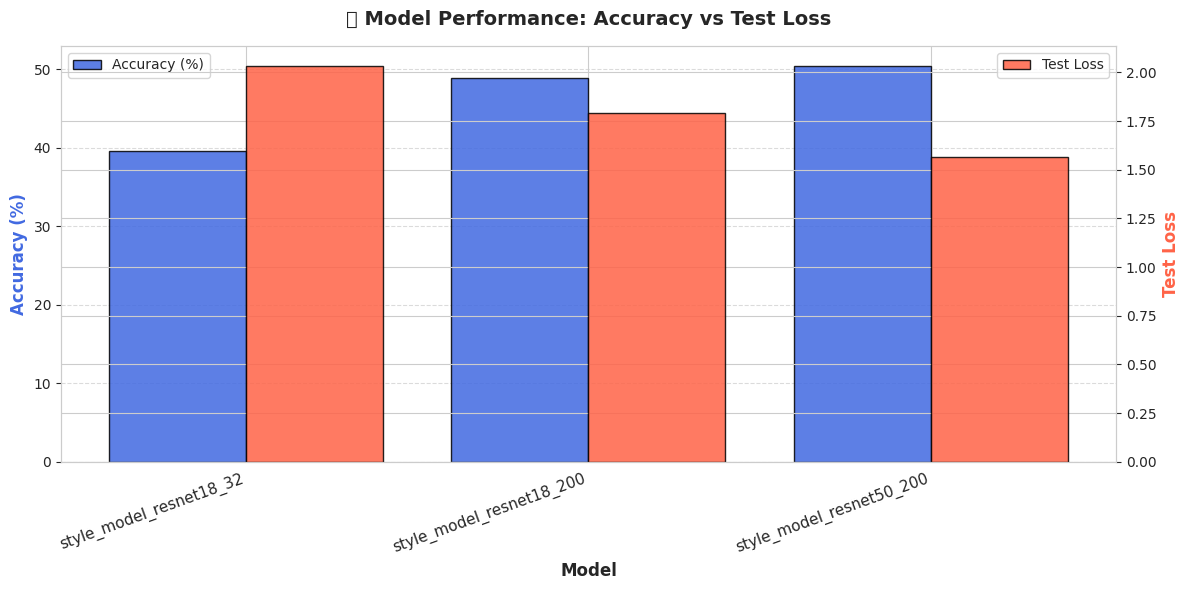

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply Seaborn style
sns.set_style("whitegrid")

# Create figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# X-axis labels and positions
x_labels = df["Model"]
x = np.arange(len(x_labels))

# Plot Accuracy Bars
ax1.bar(
    x - 0.2, df["Accuracy (%)"], width=0.4, label="Accuracy (%)",
    color='royalblue', edgecolor="black", alpha=0.85
)

# Create a secondary axis for Test Loss
ax2 = ax1.twinx()
ax2.bar(
    x + 0.2, df["Test Loss"], width=0.4, label="Test Loss",
    color='tomato', edgecolor="black", alpha=0.85
)

# Formatting
ax1.set_xlabel("Model", fontsize=12, fontweight="bold")
ax1.set_ylabel("Accuracy (%)", color='royalblue', fontsize=12, fontweight="bold")
ax2.set_ylabel("Test Loss", color='tomato', fontsize=12, fontweight="bold")

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=20, ha="right", fontsize=11)

# Add grid lines
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Add Legends
ax1.legend(loc="upper left", fontsize=10, frameon=True)
ax2.legend(loc="upper right", fontsize=10, frameon=True)

# Add title
plt.title("📊 Model Performance: Accuracy vs Test Loss", fontsize=14, fontweight="bold", pad=15)

# Improve layout
plt.tight_layout()
plt.show()


## Genre Models

In [ ]:
print("Creating balanced style dataset...")

genre_test_balanced_dataset = BalancedArtDataset(genre_val_path, "/content/drive/MyDrive/data/images", genre_class_path, transform=transform, images_per_class=50)



Creating balanced style dataset...
Filtering missing images...
Grouping images by class...


Processing rows: 100%|██████████| 19492/19492 [00:02<00:00, 7952.10it/s]


Balancing dataset...


Processing classes: 100%|██████████| 10/10 [00:00<00:00, 9642.08it/s]

Filling missing slots...
Shuffling dataset...


In [ ]:
num_genre_classes = len(genre_class)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


genre_model1 = models.resnet18(weights=None)  # Initialize model without pre-trained weights
genre_model1.fc = nn.Linear(genre_model1.fc.in_features, num_genre_classes)  # Modify the FC layer
genre_model1 = genre_model1.to(device)

# Load state_dict (weights) into model
checkpoint_path =  "/content/drive/MyDrive/art_model/genre_model_resnet18_200.pth"
state_dict = torch.load(checkpoint_path, map_location=device)  # Load weights
genre_model1.load_state_dict(state_dict)  # Load into model

# Set to evaluation mode
genre_model1.eval()

print("Model successfully loaded!")


Model successfully loaded!


In [ ]:
# Example usage:
#style_model_resnet18_32
genre_model1_result = test_model(genre_model1, genre_test_balanced_dataset, device)


Testing: 100%|██████████| 16/16 [01:05<00:00,  4.06s/it, loss=0.931]


Test Loss: 0.9571, Accuracy: 68.40%


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


genre_model2 = models.resnet18(weights=None)  # Initialize model without pre-trained weights
genre_model2.fc = nn.Linear(genre_model2.fc.in_features, num_genre_classes)  # Modify the FC layer
genre_model2 = genre_model2.to(device)

# Load state_dict (weights) into model
checkpoint_path =  "/content/drive/MyDrive/art_model/genre_model_resnet18__450.pth"
state_dict = torch.load(checkpoint_path, map_location=device)  # Load weights
genre_model2.load_state_dict(state_dict)  # Load into model

# Set to evaluation mode
genre_model2.eval()

print("Model successfully loaded!")


Model successfully loaded!


In [ ]:
# Example usage:
#style_model_resnet18_32
genre_model2_result = test_model(genre_model2, genre_test_balanced_dataset, device)


Testing: 100%|██████████| 16/16 [01:03<00:00,  3.99s/it, loss=0.752]


Test Loss: 1.0410, Accuracy: 68.40%


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


genre_model3 = models.resnet50(weights=None)  # Initialize model without pre-trained weights
genre_model3.fc = nn.Linear(genre_model3.fc.in_features, num_genre_classes)  # Modify the FC layer
genre_model3 = genre_model3.to(device)

# Load state_dict (weights) into model
checkpoint_path = "/content/drive/MyDrive/art_model/genre_model_resnet50_450.pth"
state_dict = torch.load(checkpoint_path, map_location=device)  # Load weights
genre_model3.load_state_dict(state_dict)  # Load into model

# Set to evaluation mode
genre_model3.eval()

print("Model successfully loaded!")


Model successfully loaded!


In [ ]:
# Example usage:
#style_model_resnet18_32
genre_model3_result = test_model(genre_model3, genre_test_balanced_dataset, device)


Testing: 100%|██████████| 16/16 [02:27<00:00,  9.24s/it, loss=0.804]


Test Loss: 0.8283, Accuracy: 74.20%


In [ ]:
import pandas as pd

# Number of classes
num_classes = len(style_class)  # Update this based on your dataset

# Store all model results in a list
results = [
    ("genre_model_resnet18_200", genre_model1_result[0], genre_model1_result[1], 32, 32 * num_genre_classes),
    ("genre_model_resnet18_450", genre_model2_result[0], genre_model2_result[1], 200, 200 * num_genre_classes),
    ("genre_model_resnet50_450", genre_model3_result[0], genre_model3_result[1], 200, 200 * num_genre_classes),

]

# Create a DataFrame
df = pd.DataFrame(results, columns=["Model", "Test Loss", "Accuracy (%)", "Images per Class", "Total Images"])

# Display the table
print(df)


                      Model  Test Loss  Accuracy (%)  Images per Class  \
0  genre_model_resnet18_200   0.957108          68.4                32   
1  genre_model_resnet18_450   1.041029          68.4               200   
2  genre_model_resnet50_450   0.828285          74.2               200   

   Total Images  
0           320  
1          2000  
2          2000  


In [ ]:
from tabulate import tabulate

# Print the table in a structured format
print(tabulate(df, headers='keys', tablefmt='grid'))


+----+--------------------------+-------------+----------------+--------------------+----------------+
|    | Model                    |   Test Loss |   Accuracy (%) |   Images per Class |   Total Images |
+====+==========================+=============+================+====================+================+
|  0 | genre_model_resnet18_200 |    0.957108 |           68.4 |                 32 |            320 |
+----+--------------------------+-------------+----------------+--------------------+----------------+
|  1 | genre_model_resnet18_450 |    1.04103  |           68.4 |                200 |           2000 |
+----+--------------------------+-------------+----------------+--------------------+----------------+
|  2 | genre_model_resnet50_450 |    0.828285 |           74.2 |                200 |           2000 |
+----+--------------------------+-------------+----------------+--------------------+----------------+


<ipython-input-24-7035ce5ebb8c>:48: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


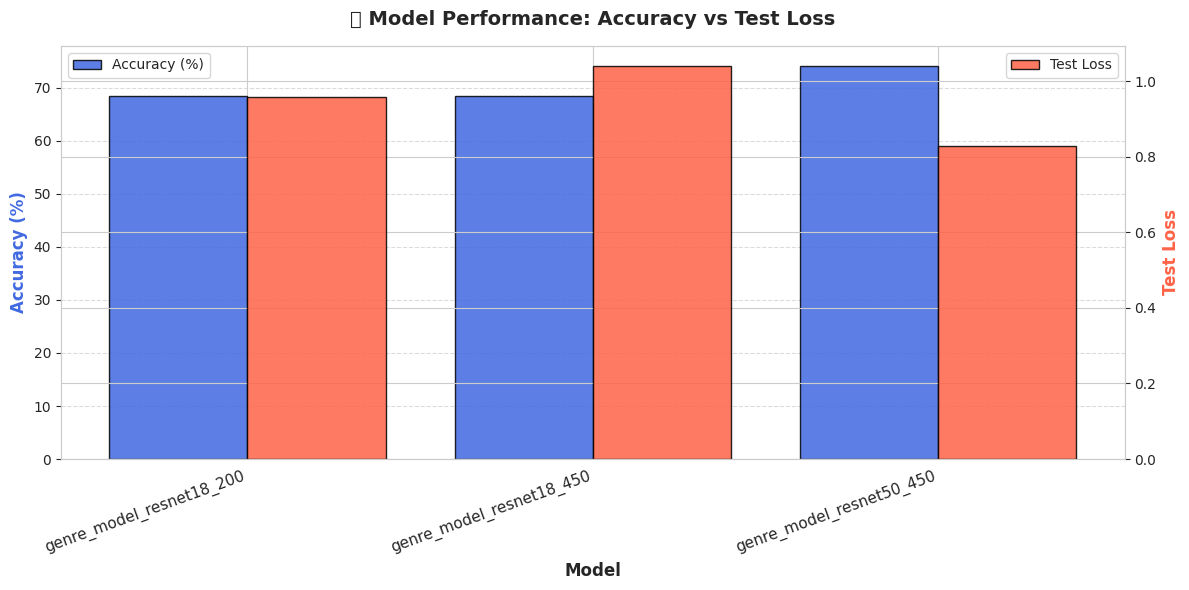

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply Seaborn style
sns.set_style("whitegrid")

# Create figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# X-axis labels and positions
x_labels = df["Model"]
x = np.arange(len(x_labels))

# Plot Accuracy Bars
ax1.bar(
    x - 0.2, df["Accuracy (%)"], width=0.4, label="Accuracy (%)",
    color='royalblue', edgecolor="black", alpha=0.85
)

# Create a secondary axis for Test Loss
ax2 = ax1.twinx()
ax2.bar(
    x + 0.2, df["Test Loss"], width=0.4, label="Test Loss",
    color='tomato', edgecolor="black", alpha=0.85
)

# Formatting
ax1.set_xlabel("Model", fontsize=12, fontweight="bold")
ax1.set_ylabel("Accuracy (%)", color='royalblue', fontsize=12, fontweight="bold")
ax2.set_ylabel("Test Loss", color='tomato', fontsize=12, fontweight="bold")

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=20, ha="right", fontsize=11)

# Add grid lines
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Add Legends
ax1.legend(loc="upper left", fontsize=10, frameon=True)
ax2.legend(loc="upper right", fontsize=10, frameon=True)

# Add title
plt.title("📊 Model Performance: Accuracy vs Test Loss", fontsize=14, fontweight="bold", pad=15)

# Improve layout
plt.tight_layout()
plt.show()
